# SWAP Test

#### The SWAP test is a simple quantum circuit (as you will see in the further sections of this notebook) which, given two states, allows to compute how much do they differ from each other. 

In this notebook we will try to cover the following sub-tasks:
<ol>
<li>Build a variational circuit which generates the most general 1 qubit state (any point in the Bloch sphere can be reached). 
<li>Using the circuit (built in step 1) and the SWAP test, find the best choice of parameters to reproduce a randomly generated quantum state made with 1 qubit.
<li>Generalize the SWAP test for a random N-qubit product state (each of the qubits are in the state |0> or |1>). For example, the state
|a> = |01>
Is a product state, while the state
|b> = |00> + |11>
Is not.
<li>Perform a qubit by qubit SWAP test to reconstruct the state. This part of the problem can be solved via a simple grid search.
</ol>


In [1]:
# Importing standard Qiskit libraries
from math import pi,sin,cos,asin,acos,sqrt,ceil
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
import random


# Importing the helper functions
from swap_test_state_solver import *

In [2]:
backend = Aer.get_backend('statevector_simulator')
backend2 = Aer.get_backend('qasm_simulator')

## Subtask 1 : Generate a general qubit state

#### The function **create_state()** can be used to generate a general/random state on qubit of a quantum circuit.

#### Important:
$\theta$ : Angle from z-axis in bloch sphere, if None then takes a random value in the range [$0,\pi$]<br>
$\phi$ : Phase angle from x-axis in bloch sphere, if None then takes a random value in the range [$0,2pi$]

In [3]:
help(create_state)

Help on function create_state in module swap_test_state_solver:

create_state(qc, i, theta=None, phi=None, mode='u')
    Creates a general qubit state given by the parameters of bloch sphere at a qubit of given quantum circuit.
    
    Parameters:
    qc : Quantum circuit of the qubit
    i : Index of the qubit in qc which is to be transformed to a general state
    theta : Angle from z-axis in bloch sphere, if None then takes a random value in the range [0,pi]
    phi : Phase angle from x-axis in bloch sphere, if None then takes a random value in the range [0,2*pi]
    mode : Uses single u3 gate (which is more efficient) by default to create the state, else if mode is 'rot' then uses separate rotation about y and z axis in the bloch sphere



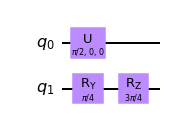

In [4]:
qc = QuantumCircuit(2)
create_state(qc,0,pi/2,0)
create_state(qc,1,pi/4,3*pi/4,mode='rot')
qc.draw('mpl')


This function can be used to create a general qubit state on any qubit of any given quantum circuit and has been used inside other functions for the same.

If any of the parameters of bloch sphere **(theta,phi)** is not provided that particular parameter takes a random value. Therefore a random general state can be produced by providing none of these values.

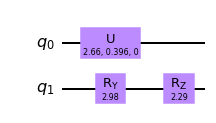

In [6]:
qc = QuantumCircuit(2)
create_state(qc,0)
create_state(qc,1,mode='rot')
qc.draw('mpl')


Alternatively the function **variational_circuit()** can be used to generate a circuit of size 1 qubit that uses the **create_state()** function under the hood to act like a variational circuit which could generate any general/random 1 qubit state given by the parameters (theta,phi) of the bloch_shere.

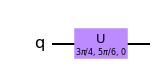

In [8]:
qc = variational_circuit(3*pi/4, 5*pi/6)
qc.draw('mpl')

### SWAP test 

We will be using the quantum **SWAP test** to test the similarity between two quantum states.

In the circuit below, for instance, '$q_0$' serves the purpose of **ancilla qubit**, and '$q_1$' and '$q_2$' are the **system qubits** whose overlap/similarity needs to be checked.

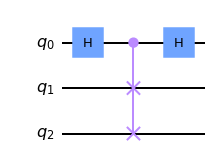

In [10]:
swap_circuit.draw('mpl')

This circuit is defined as the **swap_circuit** and can be appended to any circuit to measure the ancilla qubit and find the similarity betweeen the system qubits.

When the ancilla measured after applying the swap circuit to any given system qubits, the probability of measuring |0> in the ancilla qubit is given by the expresssion, 

### <center>$P(q_0=0) = \frac{1}{2}\left( 1 + {|<q_1|q_2>|}^2 \right\)\$</center>

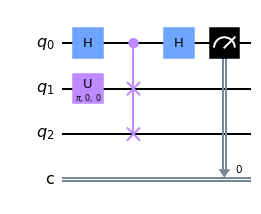

In [13]:
qc = qc + swap_circuit
qc.measure(0,0)
qc.draw('mpl')

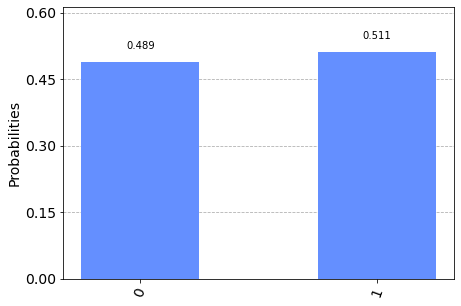

In [14]:
counts = execute(qc,backend2).result().get_counts()
plot_histogram(counts)

Alternatively, the function **swap_test()** can be used to directly find the probability of measuring '0' state in the ancilla qubit of two system qubits whose states are provided as parameters.

In [19]:
help(swap_test)

Help on function swap_test in module swap_test_state_solver:

swap_test(state1=(0, 0), state2=(0, 0), n=5000)
    Finds the probability of '0' state in the ancilla qubit after creating the desired system states (those which 
    needs to be tested) on the given quantum circuit and appending a swap test circuit at the desired positions.
    
    Parameters:
    state1 : Tuple containing parameters (theta1,phi1) in bloch sphere which describe the state of q1
    state2 : Tuple containing parameters (theta2,phi2) in bloch sphere which describe the state of q2 
    n : number of shots
    
    Returns:
    prob_zero : A float number containing the probability to measure ancilla qubit in stat |0> for n shots



Probability of measurig ancilla qubit in state |0> = 0.7526


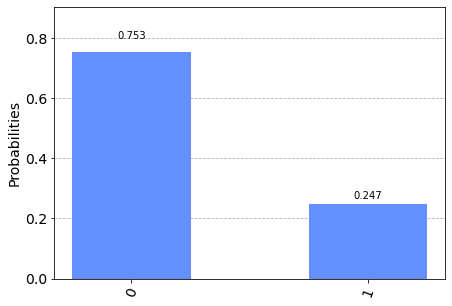

In [20]:
prob_zero = swap_test((pi/4,pi/4),(3*pi/4,pi/4))
print(f'Probability of measurig ancilla qubit in state |0> = {prob_zero}')
plot_histogram({'0':prob_zero,'1':1-prob_zero})

## Subtask 2 :Finding the state of an unknown general qubit  

The function **general_qubit_state_solver()** finds the best choice of parameters (theta, phi) using SWAP test to reproduce the given/randomly generated state of a single qubit. It can be used either using SWAP test in a single (Z) basis or in all three (X, Y and Z) basis.

In [21]:
help(general_qubit_state_solver)

Help on function general_qubit_state_solver in module swap_test_state_solver:

general_qubit_state_solver(theta=None, phi=None, multi=False)
    Finds the best choice of parameters (theta, phi) using SWAP test to reproduce the given general state or a randomly generated state of a single qubit. 
    
    If incomplete or no quantum state is passed as arguments, a general single qubit state is randomly created using the create_state() function.
    
    Parameters:
    theta : angle from z-axis in bloch sphere, if None then takes a random value in the range [0,pi]
    phi : phase angle from x-axis in bloch sphere, if None then takes a random value in the range [0,2*pi]
    multi : the number of basis to be used for SWAP testing. By default False indicates single (Z) basis is used 
    which needs 4 SWAP tests to find the correct values of parameters (theta, phi), less efficient but less error. 
    If True then all three (X, Y and Z) basis are used it needs only 3 SWAP test but more err

### Single basis SWAP test

Here the SWAP tests are conducted as usual, each time optimizing the choices of the parameters (theta,phi) depending on the similarity obtained between the currently hypothesized state and the unknow state.

All these operations are performed by a single function **general_qubit_state_solver()**.

In [29]:
general_qubit_state_solver()

Qubit State : (2.3436281195779856, 1.9163715186897738)
Predicted State : (2.395578563454773, 1.9556547403686189)


### Multi-basis SWAP test

Here the basis-specific SWAP tests are conducted in all three basis (X, Y and Z) but instead of optimizing any hypothesized state, we predict a state only once according to the measurement obtained in all three basis. 

All these operations are performed by a single function **general_qubit_state_solver()** by setting the parameter **multi = True**

In [32]:
general_qubit_state_solver(multi=True)

Qubit State : (0.6597344572538566, 1.6524777357882312)
Predicted State : (0.6671310749183624, 1.6332368930189847)


## Subtask 3 : Reconstruct a random product state of N qubits

The function **prod_state_reconstruct()** reconstructs a given/random product state using SWAP test. It can be implemented either using individual SWAP tests or by multi-qubit SWAP test on all possible n-qubit state using grid search.

This function returns a quantum circuit with N qubits with the reconstructed state, and the unknown product state and the predicted product state in the form of binary strings.

In [24]:
help(prod_state_reconstruct)

Help on function prod_state_reconstruct in module swap_test_state_solver:

prod_state_reconstruct(n, s=None, max_qubits=27, grid_search=False)
    Finds the product state using qubit by qubit SWAP test with n qubits. 
    
    Parameters:
    n : Number of qubits in the quantum product state
    s : Binary string representing the given n-qubit product state, if None then takes a random value
    max_qubits : Maximum number of qubits (including system and ancilla) that can be used for conducting the SWAP tests 
    
    Returns:
    qc : QuantumCircuit with n-qubits representing the reconstructed (predicted) product state 
    s : Binary string representing the given n-qubit product state
    pred_s : Binary string representing the predicted n-qubit product state



### Qubit by Qubit individual SWAP test

Here we find the product state using individual ancilla qubit for each individual qubit by qubit SWAP test.

All these operations are performed by a single function **prod_state_reconstruct()**.

Qubit State : 10010111
Predicted State : 10010111


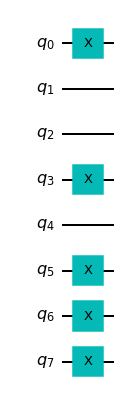

In [35]:
qc,s,pred_s = prod_state_reconstruct(8)
qc.draw('mpl')

### Grid search on multi-qubit SWAP test

Here we find the product state using only one ancilla qubit for the multi-qubit SWAP test and grid search over all possible product states with n qubits until we find the one which completely overlaps with the unknown state.

All these operations are performed by a single function **prod_state_reconstruct()** by setting the parameter **grid_search = True**.

Qubit State : 11101
Predicted State : 11101


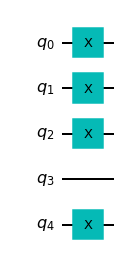

In [63]:
qc,s,pred_s = prod_state_reconstruct(5,grid_search=True)
qc.draw('mpl')